In [1]:
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
interactions_train = pd.read_csv("/content/interactions_train.csv")
interactions_test = pd.read_csv('/content/interactions_test.csv')
# raw_interactions = pd.read_csv("/content/RAW_interactions.csv")
# raw_recipes = pd.read_csv("/content/RAW_recipes.csv")

In [3]:
#interactions_train.drop(columns=['user_id', 'recipe_id']).rename(columns={'u': 'user_id', 'i': 'recipe_id'})
interactions_train.head(5)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


<Axes: >

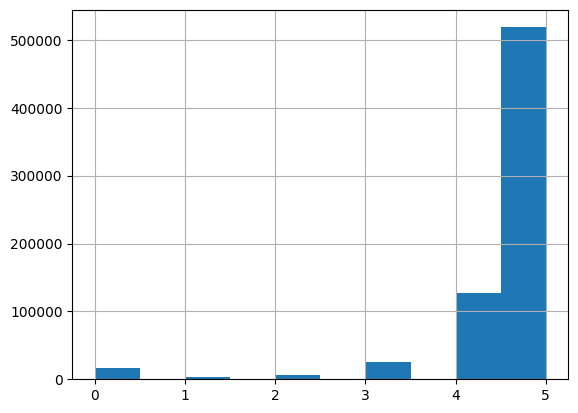

In [4]:
interactions_train['rating'].hist()

<Axes: >

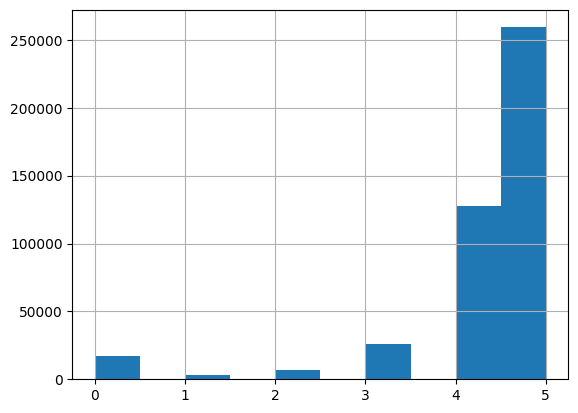

In [14]:
# size_5 = len(interactions_train[interactions_train['rating'] == 5])
# new_interactions_train = pd.concat([interactions_train[interactions_train['rating']<5],
#                                     interactions_train[interactions_train['rating'] == 5].head(size_5//2)])
# new_interactions_train['rating'].hist()

In [ ]:
interactions_test.head(5)

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


In [15]:
from torch.utils.data import Dataset, DataLoader

class Ratings_Dataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()
        user_list = df['user_id'].unique()
        item_list = df['recipe_id'].unique()
        self.user2id = {w: i for i, w in enumerate(user_list)}
        self.item2id = {w: i for i, w in enumerate(item_list)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = self.item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating

trainloader = DataLoader(Ratings_Dataset(interactions_train), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Dataset(interactions_test), batch_size=64, num_workers=2)

In [16]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

In [17]:
from statistics import mean

def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

def test(model, testloader, m_eval=False):
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5

In [18]:
n_user = interactions_train.user_id.nunique()
n_items = interactions_train.recipe_id.nunique()

model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
test(model, testloader)

tensor(0.9865, device='cuda:0')

In [20]:
users, items, r = next(iter(testloader))
users = users.cuda()
items = items.cuda()
r = r.cuda()

y = model(users, items)*5
print("ratings", r[:20].data)
print("predictions:", y.flatten()[:20].data)

ratings tensor([4., 4., 0., 2., 3., 5., 0., 5., 0., 5., 4., 5., 5., 5., 4., 5., 5., 5.,
        5., 5.], device='cuda:0')
predictions: tensor([4.9787, 4.8771, 4.8378, 3.9774, 4.9705, 4.7759, 4.7894, 4.5361, 3.7542,
        4.9987, 3.4471, 4.5359, 4.8397, 4.9634, 3.8006, 3.0137, 4.9836, 3.7790,
        4.9116, 3.3811], device='cuda:0')


(array([ 2.,  0.,  0.,  1.,  1.,  3.,  6., 12.,  9., 30.]),
 array([0.09605585, 0.58632159, 1.07658744, 1.56685317, 2.05711889,
        2.54738474, 3.03765035, 3.52791619, 4.0181818 , 4.50844765,
        4.99871349]),
 <BarContainer object of 10 artists>)

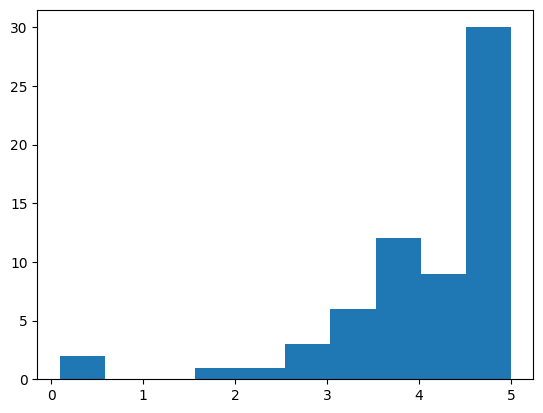

In [30]:
import matplotlib.pyplot as plt

plt.hist(y.flatten().cpu().detach().numpy())

In [31]:
torch.save(model.state_dict(), "weight.pth")